In [194]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os




In [222]:
datapath="C:/Users/20112/Desktop/keras-video-classification/keras-video-classification/data"
outputlabelbinarizer="C:/Users/20112/Desktop/keras-video-classification/keras-video-classification/model/videoclassificationbinarizer"
outputmodel="C:/Users/20112/Desktop/keras-video-classification/keras-video-classification/output/videoclassificationmodel"
epoch=25
# INIT_LR = 1e-3
# BS = 32

# initialize the set of labels from the spots activity dataset we are
# going to train our network on
LABELS = set([ "qutub_minar","alai_darwaza","iron_pillar"])


In [196]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(datapath))
data = []
labels = []

[INFO] loading images...


In [197]:
# from tensorflow.keras.preprocessing.image import img_to_array


In [198]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# if the label of the current image is not part of of the labels
	# are interested in, then ignore the image
	if label not in LABELS:
		continue

	# load the image, convert it to RGB channel ordering, and resize
	# it to be a fixed 224x224 pixels, ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (28, 28))
	# image = cv2.resize(image, (28, 28))
	# image = img_to_array(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)


In [199]:
# data = np.array(data)
data = np.array(data)

labels = np.array(labels)


In [1]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)


NameError: name 'LabelBinarizer' is not defined

In [209]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, stratify=labels, random_state=42)



In [210]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [211]:
# # load the ResNet-50 network, ensuring the head FC layer sets are left
# # off
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import Activation
# from tensorflow.keras.layers import MaxPooling2D


# model = Sequential()
# inputShape = (28, 28, 3)
# model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(50, (5, 5), padding="same"))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Flatten())
# model.add(Dense(500))
# model.add(Activation("relu"))
# 		# softmax classifier
# model.add(Dense(3))
# model.add(Activation("softmax"))

# # construct the head of the model that will be placed on top of the
# # the base model
# # headModel = baseModel.output
# # headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
# # headModel = Flatten(name="flatten")(headModel)
# # headModel = Dense(512, activation="relu")(headModel)
# # headModel = Dropout(0.5)(headModel)
# # headModel = Dense(len(lb.classes_), activation="softmax")(headModel)

# # # place the head FC model on top of the base model (this will become
# # # the actual model we will train)
# # model = Model(inputs=baseModel.input, outputs=headModel)



In [212]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

class LeNet:
	@staticmethod
	def build(width, height, depth, classes,
		activation="relu"):
		# initialize the model
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		

		# define the first set of CONV => ACTIVATION => POOL layers
		model.add(Conv2D(20, 5, padding="same",
			input_shape=inputShape))
		model.add(Activation(activation))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# define the second set of CONV => ACTIVATION => POOL layers
		model.add(Conv2D(50, 5, padding="same"))
		model.add(Activation(activation))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# define the first FC => ACTIVATION layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation(activation))

		# define the second FC layer
		model.add(Dense(3))

		# lastly, define the soft-max classifier
		model.add(Activation("softmax"))

	

		# return the constructed network architecture
		return model

In [213]:
from tensorflow.keras.utils import to_categorical

# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=3)
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / epoch)

model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


In [223]:
# train the network
print("[INFO] training network...")
H = model.fit(
	x=trainAug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=epoch, verbose=1)

[INFO] training network...
Epoch 1/25
20/20 [==============================] - 1s 39ms/step - loss: 0.9345 - accuracy: 0.5813 - val_loss: 0.9408 - val_accuracy: 0.5938
Epoch 2/25
20/20 [==============================] - 1s 37ms/step - loss: 0.9413 - accuracy: 0.5602 - val_loss: 0.9166 - val_accuracy: 0.6302
Epoch 3/25
20/20 [==============================] - 1s 45ms/step - loss: 0.9124 - accuracy: 0.5891 - val_loss: 0.9054 - val_accuracy: 0.5990
Epoch 4/25
20/20 [==============================] - 1s 58ms/step - loss: 0.8750 - accuracy: 0.6228 - val_loss: 0.8541 - val_accuracy: 0.6354
Epoch 5/25
20/20 [==============================] - 1s 58ms/step - loss: 0.8993 - accuracy: 0.5891 - val_loss: 0.8961 - val_accuracy: 0.6458
Epoch 6/25
20/20 [==============================] - 1s 58ms/step - loss: 0.9144 - accuracy: 0.5778 - val_loss: 0.8570 - val_accuracy: 0.5833
Epoch 7/25
20/20 [==============================] - 1s 57ms/step - loss: 0.8859 - accuracy: 0.6100 - val_loss: 0.8496 - val_acc

In [224]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX.astype("float32"), batch_size=32)



[INFO] evaluating network...


In [225]:
print(classification_report(
	testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_, digits = 6))
print(testY.argmax(axis=1))

              precision    recall  f1-score   support

alai_darwaza   0.450000  0.290323  0.352941        31
 iron_pillar   0.689189  0.531250  0.600000        96
 qutub_minar   0.616000  0.836957  0.709677        92

    accuracy                       0.625571       219
   macro avg   0.585063  0.552843  0.554206       219
weighted avg   0.624585  0.625571  0.611103       219

[0 1 1 0 1 1 2 1 2 1 0 0 1 1 0 2 2 2 1 1 2 2 1 0 1 2 2 2 1 1 2 2 1 2 2 2 1
 2 0 1 2 2 1 2 2 0 2 1 1 1 2 1 2 1 1 2 1 0 2 0 0 1 1 1 1 1 1 0 2 0 1 2 2 1
 2 1 2 2 2 1 1 1 0 1 1 0 2 2 0 0 2 1 2 2 0 0 0 2 2 1 1 0 1 2 1 1 1 0 2 0 2
 1 1 1 2 1 1 2 1 1 0 2 2 2 2 2 1 2 1 2 1 1 2 1 2 1 1 2 2 2 1 2 2 1 1 2 2 2
 1 1 2 1 0 1 1 0 2 1 2 1 2 2 1 2 2 2 1 0 1 2 0 1 1 2 2 0 1 2 2 1 2 2 1 2 1
 1 2 2 1 1 1 2 2 2 2 1 2 1 0 1 2 1 2 1 1 2 1 1 1 2 2 2 1 1 2 1 2 0 1]


In [226]:
from collections import Counter
Counter(testY.argmax(axis=1))
Counter(predictions.argmax(axis=1))

Counter({1: 74, 2: 125, 0: 20})

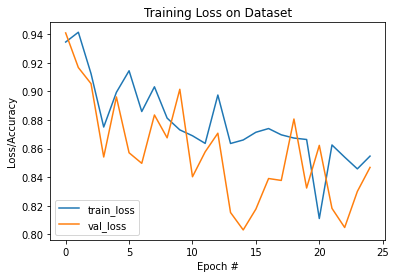

In [227]:
plt.figure()
plt.plot( H.history["loss"], label="train_loss")
plt.plot( H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()  

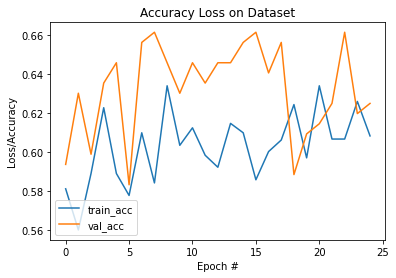

In [228]:
plt.figure()
plt.plot( H.history["accuracy"], label="train_acc")
plt.plot( H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()


In [229]:

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc



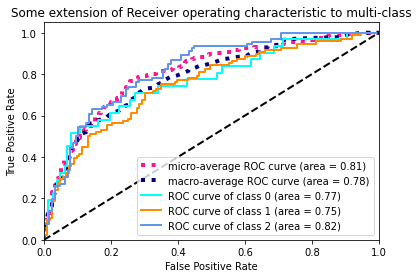

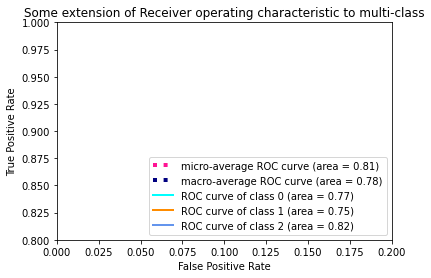

In [230]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
#y_score = model.predict(testX)
y_score=predictions
n_classes=3
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testY.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()